# コードを整理

基本的には，環境を定義して，そのクラスに行動を指定してstepメソッドを呼び出すと，報酬，次の状態，終了したかどうかのフラグが返ってくる．それらを元に行動を選択し直して再びstepメソッドを呼び出すというループである．
行動を選択し直すところでは，得られた報酬を元に期待値を更新する処理が行われている．



In [1]:
#環境の定義

__credits__ = ["Kallinteris-Andreas"]

import os
import warnings
import math
import numpy as np
import pytest
import random
from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseRightEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    右旋回を行う動作を学習し，より良くするタスク．\n
    mujoco envを継承している．
    """

    metadata = { #描画モードの種類を記載している．ここに書かれていないモードを指定された場合はエラーを出す，等の処理に使用する　変数？
        "render_modes": [ #辞書metadataのキーにrendermodesがあり、そこにはリストが割り当てられている。
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/assemble_Right_lotation.xml", frame_skip=1, **kwargs): #インスタンス作成時に自動的に実行される初期化メソッド 
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs) #継承していた「utils.EzPickle」クラスの初期化メソッドの呼び出し．pythonのEzPickleといって，イージー（簡単）にPickle化（変数をファイルとして保存できるもの）するものを使っている．

        MujocoEnv.__init__( 
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            camera_name="camera_name",
            **kwargs, # 可変長引数
        )

        self.metadata = { #またメタデータがある。インスタンス変数？
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = 14 #self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，その数をここに入れる。次元数なので数え方は０始まりではない。
        # self.wall_hit = 0
        #マイクロマウスのパラメータ用変数の用意
        self.reward_graph = []
        self.epi_reward_graph = []
        self.mouse_xpos_graph = []
        self.mouse_ypos_graph = []
        self.lastxpos_graph = []
        self.lastypos_graph = []
        self.mouse_angle_rad = math.pi/2
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.mouse_vel = 0
        self.now_time = 0
        self.past_time = 0
        self.delta_t = 0
        self.wheel_r = 0
        self.gear = 9.0e-3
        self.wheel_r = 0.0135
        self.tread = 0.072
        self.right_rotation_sum = 0
        self.left_rotation_sum = 0
        self.stepcount = 0
        self.angsum_obs = 0
        self.epi_reward = 0
        self.obsLS_graph = []
        self.obsLF_graph = []
        self.obsRS_graph = []
        self.obsRF_graph = []
        self.range_reward_x_graph = []
        self.range_reward_y_graph = []
        self.xpos_graph = []
        self.ypos_graph = []
        self.firstxyzahyou = self.init_qpos[0:3]
        self.firstquat = self.init_qpos[3:7]
        self.first_ang = (0, 0, 90)
        self.first_ang_graph = []
        


        self.observation_space = Box( #観測空間を定義．gymnasium.sapcesのBoxを使用することで簡単に定義できる．Boxは連続値を扱う．
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64 #float64型の，-無限から無限までの値を取る，11次元の観測空間を用意
        )

    def get_distance(self, model, data):
        """
        ４つの距離センサの値を取得する関数。\\
        ただし、センサ値に反応がない場合、センサ値は-0.1となるのでその場合は0.23に丸める。\\
        Returns:
            lf = 左前方の距離センサの値 \\
            ls = 左横の距離センサの値 \\
            rs = 右横の距離センサの値 \\
            rf = 右前方の距離センサの値
        """
        lf = data.sensor('LF').data[0]#sensordata[lf_id]
        ls = data.sensor('LS').data[0]#sensordata[ls_id]
        rs = data.sensor('RS').data[0]#sensordata[rs_id]
        rf = data.sensor('RF').data[0]#sensordata[rf_id]
        if lf < -0.1:
          lf = 0.3
        if ls < -0.1:
          ls = 0.3
        if rs < -0.1:
          rs = 0.3
        if rf < -0.1:
          rf = 0.3
        return lf,ls,rs,rf

    # 
    def get_odom(self, model, data): #今のタイヤの回転角度と速度（角度と角速度）を取得．
        """
            現在のタイヤの回転角度と速度（と角速度）を取得する．\\
            data.actuator().length,velocityで取得できる値はactuatorのgear倍されているので，それで割ることによって打ち消す，
            Returns:
                odm_right = 右タイヤの回転角度[rad]（基準からの総量） \\
                odm_left = 左タイヤの回転角度[rad]（基準からの総量） \\
                (vel_left) = 左タイヤの回転角速度 (単位時間あたり) \\
            """
        odm_right = data.actuator('right').length[0]/self.gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
        odm_left = data.actuator('left').length[0]/self.gear # ＝タイヤの角度
        vel_left = data.actuator('left').velocity[0]/self.gear # ＝タイヤの回転角速度
        return odm_right, odm_left
    
    def get_pulse_count(self, pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
        """
            回転量の差から，出たパルスの数を求める． (エンコーダの役割をする関数)\\
            
            Returns:
                right_pulse_num = 右タイヤのパルス数 \\
                left_pulse_num = 左タイヤのパルス数
            """
        
        pre_right_rotation_sum = self.right_rotation_sum #１つまえの回転量取得
        pre_left_rotation_sum = self.left_rotation_sum
        self.right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）（小数で、0から1で回転を表していたものを0から4096で表すようにした）
        self.left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        right_pulse_num = int(self.right_rotation_sum) - int(pre_right_rotation_sum) #現在の回転量を足した後の回転合計値ー足す前の回転合計値　これのintが１以上なら、１パルス出たことになる。パルスが出なくても回転量の合計は溜まっていく
        left_pulse_num = int(self.left_rotation_sum) - int(pre_left_rotation_sum)
        # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
        return right_pulse_num, left_pulse_num #出たパルスの数
    
    def get_odom_at_pulse(self, right_pulse_num, left_pulse_num): #パルス数を元に、パルス数を元に、ロボットの速度と回転角速度を求める（オドメトリによる推定を行う）．
        """
            パルス数を元に、ロボットの速度と回転角速度を求める．（オドメトリによる推定を行う）\\
            Returns:
                mouse_vel = ロボットの推定速度 \\
                left_pulse_num = ロボットの推定回転速度
            """
        right_wheel_move = 2*math.pi * self.wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
        left_wheel_move = 2*math.pi * self.wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
        right_wheel_vel = right_wheel_move/self.delta_t #移動距離から，速度を求める
        left_wheel_vel = left_wheel_move/self.delta_t #移動距離から，速度を求める
        mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
        mouse_radvel = (right_wheel_vel - left_wheel_vel)/self.tread #これがマウスの旋回角速度（rad/s）
        return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた
    

    def step(self, action):
        """
          シミュレーションを1step進める。 \\
          Returns: \\
            observation, 観測空間。その行動後のエージェントが見えている状態を返す \\
            reward, 報酬の合計値 \\
            terminated = False, タスクの早期達成または強制終了条件にひっかかったわけではないが、意味のない行動をし続ける場合に陥ったときなどにエピソードを終了するフラグ。本環境ではそういう場面はないため常にFalseとなる。 \\
            truncated = タスクの早期達成または強制終了が起きたときにそれを示すもの。壁にぶつかったら強制終了が起きる。ぶつかったとき以外はFalse。 \\
            info = （現状未確認。何かの情報が入っている？）\\
        """
        #変数定義
        terminated = False
        wall_hit = 0
        course_out = 0
        goal = 0
        velocity_before = self.data.sensor("Veloci").data[0] # シミュレーションを進める前の速度センサの値を取得
        ####オドメトリ####
        self.past_time = self.data.time #シミュレーション進める前の時間を取得
        pre_odm_right, pre_odm_left = self.get_odom(self.model, self.data) #今のタイヤの回転角度と速度（角度と角速度）を取得．
        
        self.do_simulation(action, self.frame_skip)####################シミュレーション実行####################################################################################
        self.now_time = self.data.time #1step進んだ後のシミュレーションの時間を取得
        self.delta_t = self.now_time - self.past_time #シミュレーション1ステップにかかった時間を取得
        self.past_time = self.now_time #シミュレーション前の時間の変数を更新
        odm_right, odm_left = self.get_odom(self.model, self.data)# エンコーダをもう一度読み取る　（行動後の値を取得）
        
        right_pulse_num, left_pulse_num = self.get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# シミュレーション前後のエンコーダ値から，この一瞬に出たパルス数を算出し，
        mouse_vel, mouse_rad_vel = self.get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度の推定値を求める。　これで，エンコーダによるマウスの速度・角速度が推定できた
        # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        self.mouse_angle_rad += mouse_rad_vel * self.delta_t #マウスの角速度はパルスの左右差で求められる。現在の角度は角速度に時間をかけた角度変化量を合計していくと求まる。
        self.mouse_xpos += mouse_vel * math.cos(self.mouse_angle_rad) * self.delta_t #向いている角度と、進んでいる速度の情報から、ロボットの現在のx座標を更新する。
        self.mouse_ypos += mouse_vel * math.sin(self.mouse_angle_rad) * self.delta_t #y座標版
        self.mouse_xpos_graph.append(self.mouse_xpos)
        self.mouse_ypos_graph.append(self.mouse_ypos)
        ####オドメトリ終了####

        #velocity_after = self.data.sensor("Veloci").data[0] # 今の速度センサの値を取得
        #mouse_vel = velocity_after - velocity_before #速度センサの値による、ロボットの速度を求める,,,速度ー速度で、速度変化を求めているけどつかわなそう。なんだこれ
        # if mouse_vel < 0:
        #     3*mouse_vel
        self.mouse_vel = mouse_vel #ロボットの推定速度値をインスタンス変数に保存しておく処理
        
        #センサ値取得
        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]左右のセンサ値取得
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        center_sensor = ls - rs

        hit_wall_f = self.data.sensor("HB1").data[0] #フォースセンサの値取得
        hit_wall_b = self.data.sensor("HB2").data[0] #フォースセンサの値取得
        truncated = False
        terminated = False
        # print("hit wall", hit_wall_f, hit_wall_b)
        if hit_wall_f > 0 or hit_wall_b > 0: #どちらかのセンサが壁にぶつかったことを検出したら
            # print("hit")
            # self.wall_hit = -10
            wall_hit = -1
            # print("hit wall", hit_wall_f, hit_wall_b)
            truncated = True
        mouse_Xpos = self.data.qpos[0]
        mouse_Ypos = self.data.qpos[1]
        mouse_Zpos = self.data.qpos[2] 
        
        # print("mouse_Zpos", mouse_Zpos)
        # print("mouse_Ypos", mouse_Ypos)
        # print("mouse_Xpos", mouse_Xpos)
        if mouse_Zpos < -0.1: #高さ。落っこちたらコースアウト判定。でも今回は必要ない。
            course_out = -1
            # print("course_out")
            # truncated = True
            terminated = True
        if mouse_Ypos < 0.18 or mouse_Ypos > 0.36:
            course_out = -1
            # print("course_out")
            # truncated = True
            terminated = True
        if mouse_Xpos < -0.18 or mouse_Xpos > 0.36:
            course_out = -1
            # print("course_out")
            # truncated = True
            terminated = True
        # # 中心とのユークリッド距離が一定以上になったらコースアウト判定
        # if np.sqrt((mouse_Xpos - 0.27)**2 + (mouse_Ypos - 0.27)**2) > 0.5:
        #     course_out = -1
        #     # print("course_out")
        #     truncated = True

        # print("摩擦！！！！", self.model.geom_friction)

        
        center_x = self.init_qpos[0] #初期座標を取得
        center_y = self.init_qpos[1] #初期座標を取得
        range_center_x = -1 * abs(self.data.qpos[0] - center_x) #中心からの距離を計算
        range_center_y = -1 * abs(self.data.qpos[1] - center_y)
        # range_reward_x = 1/(1 + 13*range_center_x)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        # range_reward_y = 1/(1 + 13*range_center_y)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        self.range_reward_x_graph.append(range_center_x) #位置報酬をグラフに保存
        self.range_reward_y_graph.append(range_center_y) 

        mokuhyou_ang = np.array([1, 0, 0, 0]) ## 目標角度設定　　クオータニオンで表す。　右向き：[1, 0, 0, 0] 左向き：[6.123233995736766e-17 , 0, 0, 1] #正面：[0.70710678 0.         0.         0.70710678]
        
        mokuhyou_angx, mokuhyou_angy, mokuhyou_angz = self.quaternion_to_euler_numpy(mokuhyou_ang)
        z_mokuhyou_ang = mokuhyou_angz
        
        genzai_ang = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        ang_error = np.abs(genzai_ang - z_mokuhyou_ang)
        ang_reward = 1/(1 + 0.025*ang_error) #ang_errorが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        # print("ang_reward", ang_reward)
        # print("gymstepのangsum_obs:", self.angsum_obs)
        observation = self._get_obs(self.angsum_obs)
        reward = wall_hit + range_center_x + range_center_y - 0.05* np.sum(np.square(action))
        # reward = wall_hit + course_out + range_reward_x-0.5 +range_reward_y-0.5 + ang_reward[2]-0.5 - 1* np.sum(np.square(action)) # 目標との誤差に関する報酬は-0.5をつけて遠すぎると罰になるようオフセットを加えた。制御入力がでかいほど罰が大きくなることによって無駄な動きを抑制。 self.wall_hitにしないほうが（インスタンス変数にしないほうが）見通しが良い気がしたのでそうした。
        # print("wall_hit:",wall_hit , "course_out:", course_out, "range_reward:", range_reward, "ang_reward:", ang_reward)
        self.reward_graph.append(reward)
        lf, ls, rs, rf = self.get_distance(self.model, self.data)
        self.obsLS_graph.append(ls) #各センサ値をグラフに保存
        self.obsLF_graph.append(lf)
        self.obsRS_graph.append(rs)
        self.obsRF_graph.append(rf)
        self.epi_reward += reward
        info = {}
        
        
            
        if self.render_mode == "human":
            self.render()
        # print("reward", reward)
        reward = float(reward)
        return observation, reward, terminated, truncated, info
    
    # def quaternion_to_euler_numpy(self, quaternion):
    #     """
    #     クォータニオンをオイラー角（ロール、ピッチ、ヨー）に変換するための関数。この関数はnumpyを使用している。
    #     :引数(1つ)： quaternion: クォータニオンの成分 [w, x, y, z] をもつ numpy 配列またはリスト
    #     :return: 三つの角度 (ロール、ピッチ、ヨー) のタプル。タプルにしたのは、念のため。
    #     """
    #     w, x, y, z = quaternion
    #     norm = np.linalg.norm(quaternion)

    #     # 四元数がゼロまたは非常に小さい場合のチェック
    #     if np.isclose(norm, 0):
    #         return 0.0, 0.0, 0.0

    #     w, x, y, z = w / norm, x / norm, y / norm, z / norm

    #     # Roll (x-axis rotation)
    #     sinr_cosp = 2 * (w * x + y * z)
    #     cosr_cosp = 1 - 2 * (x * x + y * y)
    #     roll = np.arctan2(sinr_cosp, cosr_cosp)

    #     # Pitch (y-axis rotation)
    #     sinp = 2 * (w * y - z * x)
    #     if np.abs(sinp) >= 1:
    #         # sinpが-1から1の範囲外の場合
    #         pitch = np.copysign(np.pi / 2, sinp)
    #     else:
    #         pitch = np.arcsin(sinp)

    #     # Yaw (z-axis rotation)
    #     siny_cosp = 2 * (w * z + x * y)
    #     cosy_cosp = 1 - 2 * (y * y + z * z)
    #     yaw = np.arctan2(siny_cosp, cosy_cosp)

    #     # ラジアンを度に変換
    #     deg_roll = np.degrees(roll)
    #     deg_pitch = np.degrees(pitch)
    #     deg_yaw = np.degrees(yaw)

    #     return deg_roll, deg_pitch, deg_yaw

    def quaternion_to_euler_numpy(self, quaternion):
        w, x, y, z = quaternion
        norm = np.linalg.norm(quaternion)

        # 四元数がゼロまたは非常に小さい場合のチェック
        if np.isclose(norm, 0):
            return 0.0, 0.0, 0.0

        w, x, y, z = w / norm, x / norm, y / norm, z / norm

        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)

        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if np.abs(sinp) >= 1:
            # sinpが-1から1の範囲外の場合
            pitch = np.copysign(np.pi / 2, sinp)
        else:
            pitch = np.arcsin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)

        # ラジアンを度に変換
        deg_roll = np.degrees(roll)
        deg_pitch = np.degrees(pitch)
        deg_yaw = np.degrees(yaw)

        # 角度を [0, 360] の範囲に調整
        deg_roll = (deg_roll + 360) % 360
        deg_pitch = (deg_pitch + 360) % 360
        deg_yaw = (deg_yaw + 360) % 360

        return deg_roll, deg_pitch, deg_yaw


    # def _get_obs(self): #状態空間を取得
    #     position = self.data.qpos[0:9].flat.copy()
    #     # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
    #     lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
    #     ls = np.array([self.data.sensor('LS').data[0]])
    #     rs = np.array([self.data.sensor('RS').data[0]])
    #     rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
    #     gyro = np.array([self.data.sensor('Gyro').data])
    #     accelerometer = np.array([self.data.sensor('Accel').data])
    #     gyro_0 = np.array([gyro[0][0]])
    #     gyro_1 = np.array([gyro[0][1]])
    #     gyro_2 = np.array([gyro[0][2]])
    #     accelerometer_0 = np.array([accelerometer[0][0]])
    #     accelerometer_1 = np.array([accelerometer[0][1]])
    #     accelerometer_2 = np.array([accelerometer[0][2]])
    #     mouse_angle_rad = np.array([self.mouse_angle_rad])
    #     mouse_xpos = np.array([self.mouse_xpos])
    #     mouse_ypos = np.array([self.mouse_ypos])
    #     mouse_vel = np.array([self.mouse_vel])
    #     return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
    
    def _get_obs(self, angsum_obs): #状態空間を取得 学習のループで呼ばれる用
        angsum_obs = np.array([angsum_obs])
        # position = self.data.qpos[0:7].flat.copy() #神の視点の位置情報取得

        # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
        ls = np.array([self.data.sensor('LS').data[0]])
        rs = np.array([self.data.sensor('RS').data[0]])
        rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
        gyro = np.array([self.data.sensor('Gyro').data])
        gyro_0 = np.array([gyro[0][0]])
        gyro_1 = np.array([gyro[0][1]])
        gyro_2 = np.array([gyro[0][2]])
        accelerometer = np.array([self.data.sensor('Accel').data])
        accelerometer_0 = np.array([accelerometer[0][0]])
        accelerometer_1 = np.array([accelerometer[0][1]])
        accelerometer_2 = np.array([accelerometer[0][2]])
        mouse_angle_rad = np.array([self.mouse_angle_rad])
        mouse_xpos = np.array([self.mouse_xpos])#オドメトリによる推定座標
        mouse_ypos = np.array([self.mouse_ypos])#オドメトリによる推定座標
        mouse_vel = np.array([self.mouse_vel])
        return np.concatenate((mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        # return np.concatenate((angsum_obs, position, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        self.first_ang = self.quaternion_to_euler_numpy(self.firstquat)
        # print(self.first_ang)
        self.first_ang_graph.append(self.first_ang[2])
        # soutai_x = np.cos(np.radians(self.first_ang[2]))*(position[0]-self.firstxyzahyou[0])+np.sin(np.radians(self.first_ang[2]))*(position[1]-self.firstxyzahyou[1])
        # soutai_y = -np.sin(np.radians(self.first_ang[2]))*(position[0]-self.firstxyzahyou[0])+np.cos(np.radians(self.first_ang[2]))*(position[1]-self.firstxyzahyou[1])
        # soutai_x = np.cos(np.radians(self.first_ang[2]))*(odom_pos[0]-self.firstxyzahyou[0])+np.sin(np.radians(self.first_ang[2]))*(odom_pos[1]-self.firstxyzahyou[1])
        # soutai_y = -np.sin(np.radians(self.first_ang[2]))*(odom_pos[0]-self.firstxyzahyou[0])+np.cos(np.radians(self.first_ang[2]))*(odom_pos[1]-self.firstxyzahyou[1])
        
        # position[0] = soutai_x
        # position[1] = soutai_y
        # position[0] = position[0] - self.firstxyzahyou[0]
        # position[1] = position[1] - self.firstxyzahyou[1]
        # self.xpos_graph.append(position[0])
        # self.ypos_graph.append(position[1])

        # print(position)
        # return np.concatenate((position[0:2],lf,ls,rs,rf))

    def get_obs(self, angsum_obs): #状態空間を取得 使いたいときに使う用
        angsum_obs = np.array([angsum_obs])
        # position = self.data.qpos[0:9].flat.copy()
        # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
        ls = np.array([self.data.sensor('LS').data[0]])
        rs = np.array([self.data.sensor('RS').data[0]])
        rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
        gyro = np.array([self.data.sensor('Gyro').data])
        gyro_0 = np.array([gyro[0][0]])
        gyro_1 = np.array([gyro[0][1]])
        gyro_2 = np.array([gyro[0][2]])
        accelerometer = np.array([self.data.sensor('Accel').data])
        accelerometer_0 = np.array([accelerometer[0][0]])
        accelerometer_1 = np.array([accelerometer[0][1]])
        accelerometer_2 = np.array([accelerometer[0][2]])
        # mouse_angle_rad = np.array([self.mouse_angle_rad])
        # mouse_xpos = np.array([self.mouse_xpos])
        # mouse_ypos = np.array([self.mouse_ypos])
        # mouse_vel = np.array([self.mouse_vel])
        # return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        return np.concatenate((angsum_obs, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
    


    def random_position_around(self, center, radius):
      """
      引数
      ### 指定する中心座標
            center = np.array([0.0, 0.0, 0.0])
            ### 半径
            radius = 1.0
            ## 戻り値
            [x座標、y座標] """
      angle = np.random.uniform(0, 2 * np.pi)
      x_offset = radius * np.cos(angle)
      y_offset = radius * np.sin(angle)
      return np.array([center[0] + x_offset, center[1] + y_offset, center[2]])

    def random_quaternion_xy_plane(self):
    # z軸周りの回転角度をランダムに生成
      theta = np.random.uniform(0, 2 * np.pi)
      
      # クオータニオンの成分を計算
      q_w = np.cos(theta / 2)
      q_x = 0
      q_y = 0
      q_z = np.sin(theta / 2)
      
      return np.array([q_w, q_x, q_y, q_z])
        
    def reset_model(self):
        qpos = self.init_qpos.copy() #初期位置を取得
        # print("qpos", qpos)
        qvel = self.init_qvel.copy() #初期速度を取得
        
        # range1 = np.random.uniform(0, 0.1) # 0〜0.1の範囲からランダムに値を取得
        # range2 = np.random.uniform(0.41, 0.51) # 0.41〜0.51の範囲からランダムに値を取得
        # x_pos = np.random.choice([range1, range2])
        
        # range3 = np.random.uniform(-0.05, 0.05)
        # range4 = np.random.uniform(0.45, 0.5)
        # y_pos = np.random.choice([range3, range4])
        
        #ランダム出現
        qpos[0] = np.random.uniform(0.25, 0.29)
        qpos[1] = np.random.uniform(0.25, 0.29)
        
        # qpos[0:3] = self.random_position_around(center=np.array([0.27, 0.27, 0.0169]), radius=0.25)
        # self.firstxyzahyou = qpos[0:3]
        
        # print("リセットされた。つぎは０のはず")
        

        # qpos[3:7] = self.random_quaternion_xy_plane()
        # self.firstquat = qpos[3:7]
        # print(self.first_ang)

        
        self.stepcount = 0
        

        leftwall_on = np.random.uniform(0, 1)
        rightwall_on = np.random.uniform(0, 1)
        forwardwall_on = np.random.uniform(0, 1)
        backwall_on = np.random.uniform(0, 1)
        if leftwall_on >= 0.5:
            qpos[-1] = -0.4
        else:
            qpos[-1] = 0
        if rightwall_on >= 0.5:
            qpos[-2] = 0.4
        else:
            qpos[-2] = 0
        if forwardwall_on >= 0.5:
            qpos[-3] = 0.4
        else:
            qpos[-3] = 0
        if backwall_on >= 0.5:
            qpos[-4] = -0.4
        else:
            qpos[-4] = 0

        # x_values = [0.27, 1.07, 1.87]
        # mouse_xposition_shuffle = random.choice(x_values)
        # x_values = 0.27

        # mouse_xposition_shuffle = self.course_list[np.random]
        # mouse_yposition_shuffle = self.course_list[np.random]

        #両方3のときはやり直しする処理
        
        # qpos[0] = mouse_xposition_shuffle
        # qpos[0] = x_values
        # noise = np.random.normal(0, 0.3)  # 平均0、標準偏差0.1のノイズ
        # qpos[3] += np.random.normal(0, 0.03)#0.27 1.07
        # qpos[1] = mouse_yposition_shuffle
        self.set_state(qpos, qvel) #qposとqvelには，すべての位置と速度の値がならんでいるためそれをセットする#################
        self.mouse_angle_rad = 0
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.angsum_obs = 0

        self.epi_reward_graph.append(self.epi_reward) #収益のグラフ表示用
        self.epi_reward = 0 #収益を数え終わったから０にリセットして次のエピソードの報酬を数えていくため

        self.lastxpos = self.data.qpos[0].flat.copy() #エピソード終了時の座標を取得
        self.lastypos = self.data.qpos[1].flat.copy()
        self.lastxpos_graph.append(self.lastxpos) 
        self.lastypos_graph.append(self.lastypos)

        observation = self._get_obs(self.angsum_obs)
        #必要に応じてオドメトリ値もリセットする必要がある

        return observation

    def _get_reset_info(self):
        return {"works": True}
    
    # from typing import Any, Dict, Optional, Tuple, Union
    # def reset(
    #     self,
    #     *,
    #     seed: Optional[int] = None,
    #     options: Optional[dict] = None,
    # ):
    #     super().reset(seed=seed) #サブクラスにresetを書くとそちらだけが実行されるように隠蔽されてしまうので，スーパークラスのresetを実行して，前に定義した内容も実行する

    #     self._reset_simulation()
    #     print("リセットメソッドのオーバーライドができているか確認するためのprint文です．")

    #     ob = self.reset_model()
    #     info = self._get_reset_info()

    #     if self.render_mode == "human":
    #         self.render()
    #     return ob, info

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃オプション。特に使わない＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseRightEnv(frame_skip=frame_skip) #フレームスキップ設定の上書き？

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works \\
      訳：XMLファイルの読み込みがうまくいくことを確認する"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseRightEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseRightEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder　訳：ユーザーホームパス（'〜'を含む）をテストできないことに注意してください。github CIにはホームフォルダがありません


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseRightEnv()

    _, info = env.reset()
    assert info["works"] is True
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃オプションここまで＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃用意した環境クラスを使用し、学習済みモデルをロード＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃

import gymnasium as gym
gym.envs.registration.register(id='MouseRightEnv-v0',max_episode_steps=600,entry_point=MouseRightEnv) #環境登録 idは環境の名前付け。 max_episode_steps=600, は1エピソードの最大ステップ数 entry_point=MouseRightEnv は環境クラスの指定

from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from gymnasium.wrappers import RecordVideo
import datetime

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0) #学習にかかった時間を計測するために使用　小数の時間は切り捨て(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human") #環境クラスの作成。レンダーモードを選択 

# model = PPO("MlpPolicy", env, verbose=0) #学習モデルのインスタンスを作成。PPOを使い、MlpPolicyを使用。verbose=0は学習ログを表示しない設定
# RLmodel = PPO.load('dammy',env) #学習済みモデルの読み込み。　学習モデル（ここではRLmodel）.saveで保存したモデルを読み込める。

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
import time
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import glfw
import keyboard
import math



def action(model, data, left, right):
    """
    与えられた左右の速度の値を実際にシミュレーションに反映させる関数。\\
    最大値は3、それ以上の値なら3に丸める。
    """
    if left > 3:
        left = 3
    if right > 3:
        right = 3
    data.actuator('right').ctrl[0] = right
    data.actuator('left').ctrl[0] = left

def quaternion_to_euler_numpy(quaternion):
    """
    Converts a quaternion into Euler angles (roll, pitch, yaw) using numpy
    :param quaternion: A numpy array or list with the quaternion components [w, x, y, z]
    :return: A tuple of three angles: roll, pitch, yaw
    """
    w, x, y, z = quaternion
    norm = np.linalg.norm(quaternion)

    # 四元数がゼロまたは非常に小さい場合のチェック
    if np.isclose(norm, 0):
        return 0.0, 0.0, 0.0

    w, x, y, z = w / norm, x / norm, y / norm, z / norm

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        # sinpが-1から1の範囲外の場合
        pitch = np.copysign(np.pi / 2, sinp)
    else:
        pitch = np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    # ラジアンを度に変換
    deg_roll = np.degrees(roll)
    deg_pitch = np.degrees(pitch)
    deg_yaw = np.degrees(yaw)

    return deg_roll, deg_pitch, deg_yaw

def get_distance(model, data):
    """
    ４つの距離センサの値を取得する関数。\\
    ただし、センサ値に反応がない場合、センサ値は-0.1となるのでその場合は0.23に丸める。\\
    Returns:
        lf = 左前方の距離センサの値 \\
        ls = 左横の距離センサの値 \\
        rs = 右横の距離センサの値 \\
        rf = 右前方の距離センサの値
    """
    lf = data.sensor('LF').data[0]#sensordata[lf_id]
    ls = data.sensor('LS').data[0]#sensordata[ls_id]
    rs = data.sensor('RS').data[0]#sensordata[rs_id]
    rf = data.sensor('RF').data[0]#sensordata[rf_id]
    if lf < -0.1:
      lf = 0.3
    if ls < -0.1:
      ls = 0.3
    if rs < -0.1:
      rs = 0.3
    if rf < -0.1:
      rf = 0.3
    return lf,ls,rs,rf

def get_accel(model, data):
  """
    加速度センサの値を取得する関数。\\
    Returns:
        ax = x軸方向の加速度 \\ 
        ay = y軸方向の加速度 \\
        az = z軸方向の加速度
  """
  ax = data.sensor('Accel').data[0]
  ay = data.sensor('Accel').data[1]
  az = data.sensor('Accel').data[2]
  return ax,ay,az

def get_gyro(model, data):
  """
    ジャイロセンサの値を取得する関数。\\
    Returns:
        gx = x軸方向の角速度 \\ 
        gy = y軸方向の角速度 \\
        gz = z軸方向の角速度
  """
  gx = data.sensor('Gyro').data[0]
  gy = data.sensor('Gyro').data[1]
  gz = data.sensor('Gyro').data[2]
  return gx,gy,gz

def get_odom(model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  vel_left = data.actuator('left').velocity[0]/gear # ＝タイヤの回転角速度
  return odm_right, odm_left


def random_friction(model, data):
    if random.random() > 0.8:
        model.geom_friction[:] = 1
    else:
        model.geom_friction[:] = random.uniform(0.14, 0.21) #0.14, 0.21
    # print("摩擦係数", model.geom_friction)
    mujoco.mj_forward(model, data)#mujocoのキャッシュを更新するための処理 iranai?


def get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
  """
    回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
    Returns:
        right_pulse_num = 右タイヤのパルス数 \\
          left_pulse_num = 左タイヤのパルス数
    """
  global right_rotation_sum #総回転量を記録する変数
  global left_rotation_sum #総回転量を記録する変数
  pre_right_rotation_sum = right_rotation_sum #今までの総回転量を取得
  pre_left_rotation_sum = left_rotation_sum #今までの総回転量を取得
  right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  right_pulse_num = int(right_rotation_sum) - int(pre_right_rotation_sum) #それを整数での変化となった時のみ，パルス数として取得
  left_pulse_num = int(left_rotation_sum) - int(pre_left_rotation_sum)
  # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
  return right_pulse_num, left_pulse_num

def get_odom_at_pulse(right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  """
    パルス数からマウスの推定速度，推定角速度を算出する\\
    Returns:
        mouse_vel = マウスの推定速度 \\
          mouse_radvel = マウスの推定角速度
    """
  right_wheel_move = 2*math.pi * wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
  left_wheel_move = 2*math.pi * wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
  right_wheel_vel = right_wheel_move/delta_t #移動距離から，速度を求める
  left_wheel_vel = left_wheel_move/delta_t #移動距離から，速度を求める
  mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
  mouse_radvel = (right_wheel_vel - left_wheel_vel)/tread #これがマウスの旋回角速度（rad/s）
  return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた



paused = False
def key_callback(keycode): #スペースキーで一時停止
  #９５％の確率で，摩擦１
  # ５％の確率で，摩擦０～０．７ いや，必要ありません
  if chr(keycode) == ' ':
    global paused #グローバル変数のpausedを使用できるように，この関数のスコープ内に取り込む処理
    paused = not paused #pausedの真偽値を逆にする　trueとfalseを反転


# def P_straight_control(model, data):#左右の壁による位置補正
#     now_speed_left = data.actuator('left').ctrl[0]
#     now_speed_right = data.actuator('right').ctrl[0]
#     lf, ls, rs, rf = get_distance(model, data)
    
#     sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
#     # print(sensor_diff)
#     left_mot = kp * -sensor_diff + 0.2
#     right_mot = kp * sensor_diff + 0.2
#     global turn_flag
#     if turn_flag==1 or (lf<0.07 and rf <0.07):
#         turn_flag = 1
#         right_mot =  0.06
#         left_mot  = -0.06
#         if lf > 0.09 and rf > 0.09:
#           turn_flag = 0
#     return left_mot, right_mot

#関数化で新しく作成した関数

def mj_step_loop(model, data, loop_num): #mujocoのシミュレーションを任意の数だけ行う関数 グラフ化するときに不便かもしれないから不必要かも
  for i in range(loop_num):
    action(model, data, left_mot, right_mot)#なくても変わらない？？
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    #Vizualize
    viz_now = data.time
    if viz_now-viz_past>0.01:
      viz_past = viz_now
      viewer.sync()

def straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,):#前進0.5マス
  #最初の前進
  straight_kp = kp #デフォルトのゲインにして，変更があったらそれを使う
  straight_ki = ki
  
  I_err_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？ 補正するからおけ
  target_vel = 0
  past_time = data.time
  # mouse_xpos = 0 #globalにして，引数で受け取ったものに足して言って，戻り値として座標を返すようにすべき？？
  # mouse_ypos = 0
  viz_past = 0 #globalにすべき??
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  for kagennsoku in range(3):
    target_add_num = [0.15,0,-0.15] #各区間での目標速度を入れておくリスト
    print("目標速度：",target_add_num[kagennsoku], "＃＃＃＃＃＃＃＃")
    for mokuhyou_zahyou_kousin in range(30):
      target_vel += target_add_num[kagennsoku]/30 #0から始まって，
      err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      # print("原因説err_vel：", err_vel)
      I_err_sum += err_vel
      lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
      rs_hosei = 0
      ls_hosei = 0
      if lf < 0.07 and rf < 0.07:
          left_mot = 0.0
          right_mot = 0.0 #0.07より近づかないようにする
      else:
          if rs < 0.1 and ls < 0.1: #両方に壁がある場合のみ，補正を追加 これで吸い込まれないようにする
             rs_hosei = 8*rs
             ls_hosei = 8*ls
          left_mot = straight_kp * err_vel + straight_ki * I_err_sum + rs_hosei
          right_mot = straight_kp * err_vel + straight_ki * I_err_sum + ls_hosei
      action(model, data, left_mot, right_mot)
      # 制御周期を遅くするため，シミュレーションを100回繰り返す
      random_friction(model, data)
      for seigyosyuuki_delay in range(100):
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)#################################################################
        # lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      #Vizualize　あんまり細かく描画しすぎないように，0.01秒以上経ってたら描画するようにする
      viz_now = data.time
      if viz_now-viz_past>0.1:
        viz_past = viz_now
        viewer.sync()
      
      now_time = data.time
      delta_t = now_time - past_time #シミュレーションが1ステップ終わった後の時間を取得
      past_time = now_time
      # エンコーダをもう一度読み取る　（行動後の値を取得）
      odm_right, odm_left = get_odom(model, data)
      # エンコーダ値から，この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
      # print("関数内は：", mouse_angle_rad)
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t #オドメトリで座標推定
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left 
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  model.geom_friction[:] = 1
  #前進動作終了時に，前壁との距離が0.09より離れていたら，少しだけ前進する
  lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
  if lf > 0.11 and rf > 0.11:
    for i in range(30):
      left_mot=0.02 #少しずつ前進
      right_mot=0.02
      for _ in range(50):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        if lf < 0.07 and rf < 0.07: #少しずつ前進してるときに十分近づいたらそれ以上近づかないようにする
          left_mot = 0.0
          right_mot = 0.0 #0.09より近づかないようにする
        action(model, data, left_mot, right_mot)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
        viewer.sync()
  #近づきすぎない調整も終わったら，今度は向きの調整をする
  lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
  front_err = lf - rf
  if abs(front_err) > 0.00001:
    print("調整入りました")
    for i in range(30):
      left_mot = front_err * 50 
      right_mot = -front_err * 50 #ズレを直そうとする
      for i in range(200): #実際に直す，しかしerrが十分小さくなったら動くのをやめる
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        front_err = lf - rf
        if abs(front_err) < 0.0001: #ある程度ズレが小さくなってきたら，それ以上直さないようにする
          left_mot = 0
          right_mot = 0
        action(model, data, left_mot, right_mot)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left

def right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      # random_friction(model, data)
      for seigyosyuuki in range(100):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  # model.geom_friction[:] = 1
  xyz = quaternion_to_euler_numpy(data.qpos[3:7])
  Z = xyz[2]
  final_kakudo_graph.append(Z)
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left


def left_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      random_friction(model, data)
      # t_graph.append(data.time)
      for seigyosyuuki in range(100):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  model.geom_friction[:] = 1
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left






#Create model
# model = mujoco.MjModel.from_xml_path('../mouse_in_maze.xml')
# data = mujoco.MjData(model)
model = env.model
data = env.data

odom_right_graph = []
mouse_correct_vel_graph = []

gear = 9.0e-3
wheel_r = 0.0135
tread = 0.072
mx = 0.0
my = 0.0
psi = 0.0
past_odom_right = 0.0
past_odom_left = 0.0
# kp = 100
# st_Kp = 1.55 #ダンピング3.6e-6のときの最適なゲイン
st_Kp = 8.4
rad_Kp = 0.15
rad_vel_Kp = 2

rad_Kd = 0.00001

ki6 = 0.02
kd = 0.09
I_err_sum = 0
d_grad = 0
prev_err_rad = 0
target_vel = 0
target_rad = math.pi/2
target_rad_vel = 0
mjstep_count = 0

right_pulse_num = 0
right_pulse_num_graph = []
left_pulse_num = 0
left_pulse_num_graph = []

right_rotation_sum = 0
left_rotation_sum = 0

mouse_vel = 0
mouse_rad_vel = 0
mouse_xpos = 0
mouse_xpos_graph = []
mouse_ypos = 0
mouse_ypos_graph = []
target_vel_graph = []
err_vel_graph = []
mouse_vel_graph = []

viz_now = 0.0
viz_past = 0.0
now_time = 0
past_time = 0
turn_flag = 0
x_vel = 0
y_vel = 0
z_vel = 0
err = 0
delta_t = 0.001 #############################################制御周期を変える場合はここも変える！！！！！！
mouse_now_rad_xy = math.pi/2 #y軸方向を向いている
I_err_rad_vel_sum = 0
mouse_angle_rad = (math.pi/2)
right_mot = 0
left_mot = 0 #最初は0

#デバッグ用グラフのためのリスト
LRF_lf_graph = []
LRF_ls_graph = []
LRF_rs_graph = []
LRF_rf_graph = []
lf_sensor_graph = []
rf_sensor_graph = []
ls_sensor_graph = []
rs_sensor_graph = []
t_graph = []
kakusokudo_graph = []
rlkakusokudo_graph = []
kakudo_graph = []
final_kakudo_graph = []
rlfinal_kakudo_graph = []
rlkakudo_graph = []
right_mot_graph = []
left_mot_graph = []
x_vel_graph = []
velocimeter_graph = []
err_graph = []
err_rad_graph = []
now_kakudo_graph = []
now_kakudo_god_graph = []
kakudo_err_graph = []
target_kakudo_graph = []
gyro_graph = []
yzahyou = []
timevals = []
timevals5 = []
timevals6 = []
mouse_angle_rad_graph = []
mouse_correct_rad_vel_graph = []
mouse_rad_vel_graph = []
err_rad_vel_graph = []
target_rad_vel_graph = []
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer:
    pass

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.model` for environment variables or `env.get_wrapper_attr('model')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.data` for environment variables or `env.get_wrapper_attr('data')` that will search the reminding wrappers.
  logger.warn(


### 学習プログラム

In [2]:
# 学習
import gymnasium as gym
from stable_baselines3 import SAC, PPO ,DQN
from sb3_contrib import RecurrentPPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0" ,render_mode="human")

# video_path = "./"  # 保存先のpath
# env = RecordVideo(env, video_path, video_length=500)
# env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

# model = PPO("MlpPolicy", env, verbose=0)
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0)
# model = PPO.load('神視点位置と角度、半径0.1円上ランダム出現',env)
# render_freq = 1000  # 1000ステップごとにレンダリング
# callback = CustomCallback(render_freq)
for i in range(10000):
    model.learn(total_timesteps=20000)#progress_bar = True, callback=callback)

#     # モデルのテスト
#     obs, _ = env.reset()  # ここを修正
    
#     for unk in trange(10000):
#         # 環境の描画
#         env.render()

#         # モデルの推論
#         # print("本物のobs!",obs)
#         action, _ = model.predict(obs)
#         # print("本物のaction", action)

#         # 1ステップ実行
#         obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。
#         # print(obs)


#         # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
#         if terminated or truncated:
#             # print(obs)
#             obs, _ = env.reset() # エピソードが終了したら、環境をリセット


            
    # #モデルの保存 (1)
    # model.save('相対位置でpinだけ頼りに真ん中に行けるか実験LSTMPPO')
    print("モデルを保存しました")
        # グラフを作成
    plt.plot(env.epi_reward_graph)
    plt.show()
    # model.save('hidarimawari_housyuu_godsight_onlyxy_notight')

# print(video_path)
plt.title("各ステップの報酬値", fontname="MS Gothic")
plt.grid()
plt.xlabel("ステップ数", fontname="MS Gothic")
plt.ylabel("報酬値", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成 エピソードの数分報酬（収益）がリストに保存されるので、その数を数えてリストにしただけ　データ数なら自動で出るから必要なかった
plt.plot(t, env.reward_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

KeyboardInterrupt: 

In [ ]:
# print(video_path)
plt.title("各ステップの報酬値", fontname="MS Gothic")
plt.grid()
plt.xlabel("ステップ数", fontname="MS Gothic")
plt.ylabel("報酬値", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成 エピソードの数分報酬（収益）がリストに保存されるので、その数を数えてリストにしただけ　データ数なら自動で出るから必要なかった
plt.plot(env.reward_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

## 描画アニメーション：プロット/フレーム

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 縦軸と横軸のデータリスト
x = t  # 例として0から10までの100点
y = env.reward_graph  # 例として0から10のランダムな値

fig, ax = plt.subplots()
line, = ax.plot([], [], 'b')  # 初期線は空
ax.set_xlim(min(x), max(x))   # x軸の範囲設定
ax.set_ylim(min(y), max(y))   # y軸の範囲設定

def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x[:frame], y[:frame])
    return line,

# アニメーションの設定
ani = FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True)

# 動画として保存
ani.save('plot_animation1.mp4', writer='ffmpeg', fps=60)

# 表示（Jupyter Notebook等で必要な場合）
plt.show()



### 3プロット/フレーム

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# グラフで描画したいデータを指定
x = t  # 例として0から10までの100点
y = env.reward_graph  # 例として0から10のランダムな値
frameskip = 3

fig, ax = plt.subplots()
line, = ax.plot([], [], 'b')  # 初期線は空
ax.set_xlim(min(x), max(x))   # x軸の範囲設定
ax.set_ylim(min(y), max(y))   # y軸の範囲設定

def init():
    line.set_data([], [])
    return line,

def update(frame):
    # frame を3倍して、3プロットずつ更新する
    end_index = min(frame * frameskip, len(x))  # インデックスがリストの長さを超えないように　＃変更箇所＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
    line.set_data(x[:end_index], y[:end_index])
    return line,

# アニメーションの設定
# frames の数を調整して、全データが表示されるようにする
ani = FuncAnimation(fig, update, frames=(len(x) + 2) // 3, init_func=init, blit=True)# ＃変更箇所＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃

# 動画として保存
ani.save('plot_animation3.mp4', writer='ffmpeg', fps=30)

# 表示（Jupyter Notebook等で必要な場合）
plt.show()


### スキップフレーム指定可能&余白付き
今後の追加要素：
複数グラフの同時プロット
倍速機能


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl

# 日本語フォントの設定
mpl.rcParams['font.family'] = 'Meiryo'  # Windowsの場合
# mpl.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'  # Macの場合
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成 エピソードの数分報酬（収益）がリストに保存されるので、その数を数えてリストにしただけ　データ数なら自動で出るから必要なかった
# グラフで描画したいデータを指定
x = t  # 例として0から10までの100点
y = env.reward_graph  # 例として0から10のランダムな値
# frameskip =  #実時間とプロットの時間を一致させるためには、今のシミュレーションのtimestepが0.01だから、60fpsだと・・・？
#作りたい動画の設定
fps = 60
timestep = 0.01
video_speed_level = 2  # 実時間に対して1倍速で再生
frameskip = int(1 / (timestep * fps)) * video_speed_level  # シミュレーションのtimestepであるdt = 0.01, fps = 30の場合

fig, ax = plt.subplots()
line, = ax.plot([], [], 'b')  # 初期線は空
# x軸とy軸の範囲をデータの最小値と最大値から計算し、余白を加える
x_margin = 0.05 * (max(x) - min(x))
y_margin = 0.05 * (max(y) - min(y))
ax.set_xlim(min(x) - x_margin, max(x) + x_margin)
ax.set_ylim(min(y) - y_margin, max(y) + y_margin)

ax.grid(True)  # グリッド線を追加
ax.set_title("報酬値の変化", fontsize=16)  # タイトルを追加
ax.set_xlabel("ステップ数", fontsize=14)  # x軸ラベルを追加
ax.set_ylabel("報酬値", fontsize=14)  # y軸ラベルを追加

def init():
    line.set_data([], [])
    return line,

def update(frame):
    # frame を3倍して、3プロットずつ更新する
    end_index = min(frame * frameskip, len(x))  # インデックスがリストの長さを超えないように　＃変更箇所＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
    line.set_data(x[:end_index], y[:end_index])
    return line,

# アニメーションの設定
# frames の数を調整して、全データが表示されるようにする
ani = FuncAnimation(fig, update, frames=(len(x) + frameskip-1) // frameskip, init_func=init, blit=True)# ＃変更箇所＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃

# 動画として保存
ani.save('plot_animation.mp4', writer='ffmpeg', fps=fps) #ひきすうfpsに、上で指定したfpsを入れている。分かりづらくてすみません。

# 表示（Jupyter Notebook等で必要な場合）
plt.show()


## 複数のデータを一度にプロット

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_graph` for environment variables or `env.get_wrapper_attr('reward_graph')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mouse_xpos_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mouse_xpos_graph` for environment variables or `env.get_wrapper_attr('mouse_xpos_graph')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mouse_ypos_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do 

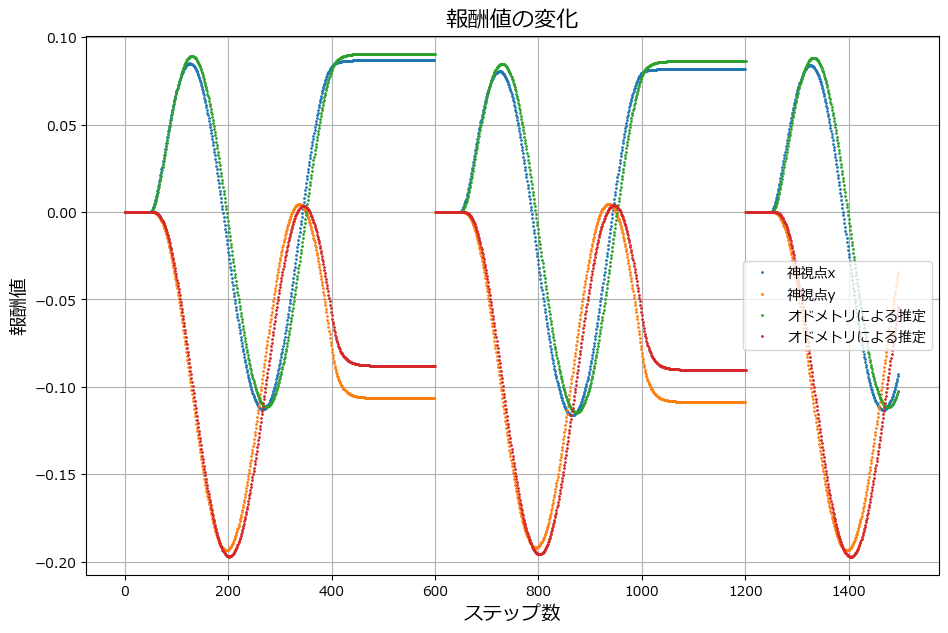

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from tqdm import tqdm

# 日本語フォントの設定
mpl.rcParams['font.family'] = 'Meiryo'  # Windowsの場合
# mpl.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'  # Macの場合

# データを用意する
t = list(range(len(env.reward_graph)))
y1 = env.mouse_xpos_graph
y2 = env.mouse_ypos_graph
y3 = env.xpos_graph
y4 = env.ypos_graph
y5 = env.obsLF_graph

# アニメーションの設定
fps = 30
timestep = 0.01
video_speed_level = 1  # 実時間に対して1倍速で再生
frameskip = int(1 / (timestep * fps)) * video_speed_level

fig, ax = plt.subplots(figsize=(11, 7))  # サイズを指定
lines = []
lines.append(ax.plot([], [], 'o', markersize=1, label='神視点x')[0])  # ラベルを追加
lines.append(ax.plot([], [], 'o', markersize=1, label='神視点y')[0])  # ラベルを追加
lines.append(ax.plot([], [], 'o', markersize=1, label='オドメトリによる推定')[0])  # ラベルを追加
lines.append(ax.plot([], [], 'o', markersize=1, label='オドメトリによる推定')[0])  # ラベルを追加
# lines.append(ax.plot([], [], 'o', markersize=1, label='step報酬')[0])  # ラベルを追加

# x軸とy軸の範囲をデータの最小値と最大値から計算し、余白を加える
x_margin = 0.05 * (max(t) - min(t))
y1_margin = 0.05 * (max(y1) - min(y1))
y2_margin = 0.05 * (max(y2) - min(y2))
y3_margin = 0.05 * (max(y3) - min(y3))
y4_margin = 0.05 * (max(y4) - min(y4))
# y5_margin = 0.15 * (max(y5) - min(y5))

ax.set_xlim(min(t) - x_margin, max(t) + x_margin) #範囲を指定している。一番小さいｔから、マージンを追加した量を足している。
ax.set_ylim(min(min(y1), min(y2), min(y3), min(y4)) - max(y1_margin, y2_margin, y3_margin, y4_margin), #y1,y2,y3の中から一番小さい値から、yのマージンの一番大きい値を引いている。
            max(max(y1), max(y2), max(y3), max(y4)) + max(y1_margin, y2_margin, y3_margin, y4_margin)) #y1,y2,y3の中から一番大きい値から、yのマージンの一番大きい値を足している。これで、すべてのデータが範囲に収まる設定となった。
# ax.set_xlim(400, 405)

ax.grid(True)
ax.legend()
ax.set_title("報酬値の変化", fontsize=16)
ax.set_xlabel("ステップ数", fontsize=14)
ax.set_ylabel("報酬値", fontsize=14)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    x_data = t[:frame * frameskip]
    lines[0].set_data(x_data, y1[:frame * frameskip])
    lines[1].set_data(x_data, y2[:frame * frameskip])
    lines[2].set_data(x_data, y3[:frame * frameskip])
    lines[3].set_data(x_data, y4[:frame * frameskip])
    # lines[4].set_data(x_data, y5[:frame * frameskip])
    return lines

ani = FuncAnimation(fig, update, frames=(len(t) + frameskip - 1) // frameskip, init_func=init, blit=True)

ani.save('plot_animation.mp4', writer='ffmpeg', fps=fps)

plt.show()

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_graph` for environment variables or `env.get_wrapper_attr('reward_graph')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.range_reward_x_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.range_reward_x_graph` for environment variables or `env.get_wrapper_attr('range_reward_x_graph')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.range_reward_y_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this vari

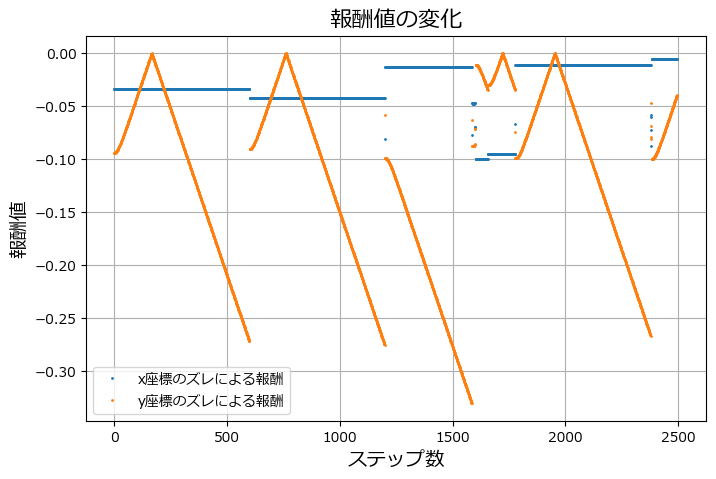

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from tqdm import tqdm

# 日本語フォントの設定
mpl.rcParams['font.family'] = 'Meiryo'  # Windowsの場合
# mpl.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'  # Macの場合

# データを用意する
t = list(range(len(env.reward_graph)))
y1 = env.range_reward_x_graph
y2 = env.range_reward_y_graph
# y3 = env.obsRS_graph
# y4 = env.obsRF_graph
# y5 = env.reward_graph

# アニメーションの設定
fps = 30
timestep = 0.01
video_speed_level = 4  # 実時間に対して1倍速で再生
frameskip = int(1 / (timestep * fps)) * video_speed_level

fig, ax = plt.subplots(figsize=(8, 5))  # サイズを指定
lines = []
lines.append(ax.plot([], [], 'o', markersize=1, label='x座標のズレによる報酬')[0])  # ラベルを追加
lines.append(ax.plot([], [], 'o', markersize=1, label='y座標のズレによる報酬')[0])  # ラベルを追加
# lines.append(ax.plot([], [], 'o', markersize=1, label='右横センサ')[0])  # ラベルを追加
# lines.append(ax.plot([], [], 'o', markersize=1, label='右前センサ')[0])  # ラベルを追加
# lines.append(ax.plot([], [], 'o', markersize=1, label='step報酬')[0])  # ラベルを追加

# x軸とy軸の範囲をデータの最小値と最大値から計算し、余白を加える
x_margin = 0.05 * (max(t) - min(t))
y1_margin = 0.05 * (max(y1) - min(y1))
y2_margin = 0.05 * (max(y2) - min(y2))
# y3_margin = 0.05 * (max(y3) - min(y3))
# y4_margin = 0.05 * (max(y4) - min(y4))
# y5_margin = 0.15 * (max(y5) - min(y5))

ax.set_xlim(min(t) - x_margin, max(t) + x_margin) #範囲を指定している。一番小さいｔから、マージンを追加した量を足している。
ax.set_ylim(min(min(y1), min(y2), ) - max(y1_margin, y2_margin,), #y1,y2,y3の中から一番小さい値から、yのマージンの一番大きい値を引いている。
            max(max(y1), max(y2),) + max(y1_margin, y2_margin, )) #y1,y2,y3の中から一番大きい値から、yのマージンの一番大きい値を足している。これで、すべてのデータが範囲に収まる設定となった。
# ax.set_xlim(400, 405)

ax.grid(True)
ax.legend()
ax.set_title("報酬値の変化", fontsize=16)
ax.set_xlabel("ステップ数", fontsize=14)
ax.set_ylabel("報酬値", fontsize=14)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    x_data = t[:frame * frameskip]
    lines[0].set_data(x_data, y1[:frame * frameskip])
    lines[1].set_data(x_data, y2[:frame * frameskip])
    # lines[2].set_data(x_data, y3[:frame * frameskip])
    # lines[3].set_data(x_data, y4[:frame * frameskip])
    # lines[4].set_data(x_data, y5[:frame * frameskip])
    return lines

ani = FuncAnimation(fig, update, frames=(len(t) + frameskip - 1) // frameskip, init_func=init, blit=True)

ani.save('plot_animation.mp4', writer='ffmpeg', fps=fps)

plt.show()

In [ ]:
print("x:", x)
print("y:", y)

### 推論を動画にする。フレームレート選べます 

In [2]:
import gymnasium as gym
import mujoco
from stable_baselines3 import PPO
import imageio
from tqdm import trange

def create_simulation_video(env_id, learned_model_path, timestep_interval, video_framerate, total_time, video_speed_level):
    """
    Stable baselines3で学習させたモデルのmujoco上の推論の動画を作成する関数
    Args:
        env_id (str): 環境ID
        learned_model_path (str): 学習済みモデルのパス
        timestep_interval (float): シミュレーションのタイムステップ間隔 (秒) xmlに定義したtimestepに合わせる
        video_framerate (int): ビデオのフレームレート (FPS)
        total_time (float): シミュレーションの総時間 (秒)
        video_speed_level (int): ビデオの再生速度 (倍)
        
    Returns:
        env (gym.Env): 環境

        使用例:
        env = create_simulation_video(
            env_id='MouseRightEnv-v0', #env_id='YourEnvironmentID',
            learned_model_path='test', #model_path='your_model_path.zip', 
            timestep_interval=0.01,  # シミュレーションのタイムステップ間隔 (秒) xmlに定義したtimestepに合わせる
            video_framerate=30,      # ビデオのフレームレート (FPS)
            total_time=14.0,         # シミュレーションの総時間 (秒)
            video_speed_level=3      # ビデオの再生速度 (倍) 実時間に対して何倍の速さで再生するかを決める。1倍ならそのまま、2倍なら2倍速で再生する
        )
    """
    # 環境とモデルのロード
    env = gym.make(env_id, render_mode="rgb_array")
    model = PPO.load(learned_model_path)
    
    

    # 環境の初期化
    obs, _ = env.reset()  # ここを修正
    frames = []

    # 設定
    total_steps = int(total_time / timestep_interval)  # timestepと実時間の要求から総ステップ数を計算 
    frame_capture_interval = int(1 / (timestep_interval * video_framerate))  # フレーム取得間隔を計算 要求のfpsの動画を作るには何秒ごとにスクショすればいいか計算している
    frame_capture_interval = frame_capture_interval*video_speed_level  #動画の実時間に対して何倍の速さで再生するかを決める。1倍ならそのまま、2倍なら2倍速で再生する
    step_no_count = 0

    # シミュレーション
    for step in trange(total_steps):
        # action, _states = model.predict(obs) #deterministicはTrueにすると、より決定論的になるそうです(?)
        step_no_count += 1
        if step_no_count <= 50:
            action = [0.0, 0.0]  # ここを修正
            # print("stepnokaunto:", step_no_count)
        elif step_no_count <= 400:
            action = [0.05, 0.3]
        else:
            action = [0.0, 0.0]
            # print("action:", action)
        obs, rewards, terminated, truncated, info = env.step(action)
        if step % frame_capture_interval == 0:
            #シミュレーション内の様子をレンダーにセット
            frame = env.render() #実際にセットしたやつの見た目を描画つまりデータで表す。そしてその描画データ（スクショ）をframe変数に保存
            frames.append(frame) #ためていく
        if truncated == True or terminated == True:
            obs, _ = env.reset()
            step_no_count = 0
    

    # ビデオの保存
    with imageio.get_writer('simulation_video.mp4', fps=video_framerate) as video:
        for frame in frames:
            video.append_data(frame)

    env.close()
    return env

# 使用
env = create_simulation_video(
    env_id='MouseRightEnv-v0', #env_id='YourEnvironmentID',
    learned_model_path='相対位置、神のみ', #model_path='your_model_path.zip', 
    timestep_interval=0.01,  # シミュレーションのタイムステップ間隔 (秒)
    video_framerate=30,       # ビデオのフレームレート (FPS)
    total_time=15.0,           # シミュレーションの総時間 (秒)
    video_speed_level=1       # ビデオの再生速度 (倍) 実時間に対して何倍の速さで再生するかを決める。1倍ならそのまま、2倍なら2倍速で再生する
)

100%|██████████| 1500/1500 [00:03<00:00, 491.67it/s]


In [ ]:
import matplotlib.pyplot as plt

# グラフを作成
plt.plot(env.epi_reward_graph)
plt.show()

In [ ]:
import mujoco
import mediapy as media

# モデルとデータの初期化
model = PPO.load('test',env)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# シミュレーションの設定
duration = 5  # シミュレーションの継続時間（秒）
framerate = 60  # フレームレート（FPS）

# ビデオフレームを格納するリスト
frames = []

# シミュレーションのリセット
mujoco.mj_resetData(model, data)

# シミュレーションループ
while data.time < duration:
    # シミュレーションを1ステップ進める
    mujoco.mj_step(model, data)
    
    # 現在の時間が次のフレームの時間を超えた場合、画像をキャプチャ
    if len(frames) < int(data.time * framerate): #シミュレーションの時間を見て、フレームレートの設定がこれだから、この時間経過したらビデオフレームはいくつ有るはず、っていう計算をして、それよりフレーム数が少なかったら取得して増やす、っていうことをやっている
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

# ビデオとして表示
media.show_video(frames, fps=framerate)


# 右回り関数の置き換え用関数を定義　強化学習推論右回り等

In [ ]:
def REright_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  
  kakudo_kp = 0.1
  kakudo_ki = 0.000
  kakudo_kd = 0.000

  r_turn_kp = 0.08
  r_turn_ki = 45
  r_turn_kd = 0.0002
  kukan_count = 0
  print("kp=", r_turn_kp)
  print("ki=", r_turn_ki)
  print("kd=", r_turn_kd)
  prev_err_rad_vel = 0
  delta_t = 0.01
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(4):
    target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6),0]
    kukan_count += 1
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    if kukan_count >= 9:
       r_turn_kp = 0.06
       r_turn_ki = 0.000
       r_turn_kd = 0.002
    for kukan in range(300):
      target_rad_vel += target_add_rad_vel[kasoku]/300 #目標回転角速度を15度/秒にすると
      # print("target:", target_rad_vel * 180/math.pi)
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      # print("err_rad_vel:", err_rad_vel * 180/math.pi)
      
      I_err_rad_vel_sum += err_rad_vel * delta_t # 目標との角速度誤差を積算
      kd_katamuki = (err_rad_vel - prev_err_rad_vel)/delta_t
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum - r_turn_kd * kd_katamuki
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum + r_turn_kd * kd_katamuki
      if left_mot > 3:
         left_mot = 3
      if left_mot < -3:
         left_mot = -3
      if right_mot > 3:
         right_mot = 3
      if right_mot < -3:
         right_mot = -3
      action(model, data, left_mot, right_mot)
      # random_friction(model, data)
      # model.geom_friction[:] = 1
      for seigyosyuuki in range(10):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        target_rad_vel_graph.append(target_rad_vel * 180/math.pi)
        err_rad_vel_graph.append(err_rad_vel)
        mouse_rad_vel_graph.append(mouse_rad_vel * 180/math.pi)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      prev_err_rad_vel = err_rad_vel
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  # model.geom_friction[:] = 1
  xyz = quaternion_to_euler_numpy(data.qpos[3:7])
  Z = xyz[2]
  final_kakudo_graph.append(Z)
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left






def angREright_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
         #角度追従のパラメータ
  kakudo_kp = 43
  kakudo_ki = 0
  kakudo_kd = 1
         #角速度追従のパラメータ
  r_turn_kp = 0.08
  r_turn_ki = 30
  r_turn_kd = 0.0005
  kukan_count = 0
  print("kp=", r_turn_kp)
  print("ki=", r_turn_ki)
  print("kd=", r_turn_kd)
  prev_err_rad_vel = 0
  delta_t = 0.001
  now_kakudo = 0
  kakudo_err_sum_I = 0
  prev_kakudo_err = 0
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  gyro_offset = np.random.normal(0, 0.000004)

  first_timer = data.time #基準となる時間を取得
  for kasoku in range(1400):
      timer = data.time - first_timer #基準となる時間からの経過時間を取得　これでfor文が始まってからの経過時間が取得できる
      if timer <= 0.3:
         target_kakudo = math.pi/0.72 * timer**2
      elif timer <= 0.6:
         target_kakudo = math.pi/1.2 * timer - math.pi/8
      elif timer <= 0.9:
         target_kakudo = -math.pi/0.72 * timer**2 + 3*math.pi/1.2 * timer - 5/8*math.pi
      now_kakudo_god = quaternion_to_euler_numpy(data.qpos[3:7])
      now_kakudo += data.sensor('Gyro').data[2] * delta_t #+ gyro_offset############################################################################################
      

      kakudo_err = target_kakudo - now_kakudo
      
      kakudo_err_sum_I += kakudo_err*delta_t
      kakudo_kd_katamuki = (kakudo_err - prev_kakudo_err)/delta_t
      target_rad_vel = kakudo_kp * kakudo_err + kakudo_ki * kakudo_err_sum_I + kakudo_kd * kakudo_kd_katamuki
      prev_kakudo_err = kakudo_err
      mouse_rad_vel = data.sensor('Gyro').data[2]
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標と実際の角速度誤差を計算
      # print("err_rad_vel:", err_rad_vel * 180/math.pi)
      
      I_err_rad_vel_sum += err_rad_vel * delta_t # 目標との角速度誤差を積算
      kd_katamuki = (err_rad_vel - prev_err_rad_vel)/delta_t
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum - r_turn_kd * kd_katamuki
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum + r_turn_kd * kd_katamuki
      if left_mot > 3:
         left_mot = 3
      if left_mot < -3:
         left_mot = -3
      if right_mot > 3:
         right_mot = 3
      if right_mot < -3:
         right_mot = -3
      action(model, data, left_mot, right_mot)
      # random_friction(model, data)
      model.geom_friction[:] = 1#0.023 +np.random.normal(0, 0.1)############################################################################################
      print(model.geom_friction[1])
      for seigyosyuuki in range(10):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        target_rad_vel_graph.append(target_rad_vel * 180/math.pi)
        target_kakudo_graph.append(target_kakudo * 180/math.pi)
        err_rad_vel_graph.append(err_rad_vel * 180/math.pi)
        mouse_rad_vel_graph.append(mouse_rad_vel * 180/math.pi)
        now_kakudo_graph.append(now_kakudo * 180/math.pi)
        now_kakudo_god_graph.append(now_kakudo_god[2])
        kakudo_err_graph.append(kakudo_err * 180/math.pi)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      prev_err_rad_vel = err_rad_vel
      # # エンコーダをもう一度読み取る
      # odm_right, odm_left = get_odom(model, data)
      # # この一瞬に出たパルス数を算出し，
      # right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # # right_pulse_num_graph.append(right_pulse_num)
      # # パルス数から，移動速度と角速度を求める
      # mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # # mouse_vel_graph.append(mouse_vel)
      # # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      # mouse_angle_rad += mouse_rad_vel * delta_t
      # mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      # mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # # mouse_xpos_graph.append(mouse_xpos)
      # # mouse_ypos_graph.append(mouse_ypos)
      # # 一つ前のodom値を更新
      # pre_odm_right = odm_right
      # pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  # model.geom_friction[:] = 1
  xyz = quaternion_to_euler_numpy(data.qpos[3:7])
  Z = xyz[2]
  final_kakudo_graph.append(Z)
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left















def RLstep_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,): #学習結果を推論する関数
    r_turn_kp = kp
    r_turn_ki = ki
    mouse_xpos = 0
    mouse_ypos = 0
    env.angsum_obs = 0
    env.model.opt.timestep = 0.001
    
    for _ in range(1200):
        past_time = data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        before_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        obs = env.get_obs(env.angsum_obs) #今の[状態]を得る
        # print("obs:",obs)
        # obs = get_obs_for_predict(model, data, env.angsum_obs) #今の[状態]を得る
        # print("ちゃんとたされていってるはずのobs", obs)
        Action, _ = RLmodel.predict(obs) #推論して，行動を受け取る
        # print("推論時に渡したobs！:",obs, "推論結果の行動:",Action)
        left_mot = Action[0] #その行動司令を変数に渡して，
        right_mot = Action[1]
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        rlkakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        rlkakudo_graph.append(Z)
        t_graph.append(data.time)
        random_friction(model, data)
        env.step(Action)
        viewer.sync()
        after_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        env.angsum_obs += after_ang[2] - before_ang[2]
        now_time = data.time# ΔTを求める
        delta_t = now_time - past_time
        past_time = now_time
        ####オドメトリ####
        odm_right, odm_left = get_odom(model, data) # エンコーダをもう一度読み取る
        right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# この一瞬に出たパルス数を算出し，
        mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度を求める#これで，エンコーダによるマウスの速度・角速度が推定できた
        mouse_angle_rad += mouse_rad_vel * delta_t # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
        mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
        pre_odm_right = odm_right# 一つ前のodom値を更新
        pre_odm_left = odm_left
        ####オドメトリ####
    env.angsum_obs = 0
    env.model.opt.timestep = 0.0001
    model.geom_friction[:] = 1
    xyz = quaternion_to_euler_numpy(data.qpos[3:7])
    Z = xyz[2]
    rlfinal_kakudo_graph.append(Z)
    return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left



def reload_xy_by_odometly(pre_odm_right, pre_odm_left, mouse_angle_rad, mouse_xpos, mouse_ypos):
    odm_right, odm_left = get_odom(model, data) # エンコーダをもう一度読み取る
    right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# この一瞬に出たパルス数を算出し，
    mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度を求める#これで，エンコーダによるマウスの速度・角速度が推定できた
    mouse_angle_rad += mouse_rad_vel * delta_t # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
    mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
    mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
    pre_odm_right = odm_right# 一つ前のodom値を更新
    pre_odm_left = odm_left
    return mouse_angle_rad, mouse_xpos, mouse_ypos

### プログラム実行の部分

In [ ]:
#Main Loop
looping = 0
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(3) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  obs, _ = env.reset()
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = RL_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
  print("最初の１マス進む処理")
  target_vel = 0
  # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      env.angsum_obs = 0
      env.model.opt.timestep = 0.0001
      looping += 1

      model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = angREright_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=5,) #右にカーブ
      # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      # model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #左にカーブ
      # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
      # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進

      



      
      left_mot = 0
      right_mot = 0
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      for seigyosyuuki2 in range(7000):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
        viewer.sync()
        # target_rad_vel_graph.append(target_rad_vel * 180/math.pi)
        # left_mot_graph.append(left_mot)
        # right_mot_graph.append(right_mot)
        # zkakusokudo_rad = data.sensor('Gyro').data[2]
        # zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        # kakusokudo_graph.append(zkakusokudo_ang)
        # xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        # Z = xyz[2]
        # kakudo_graph.append(Z)
        # t_graph.append(data.time)
      env.reset_model()
      for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break
      if looping >= 1:
        break
      kakudo_graph = []
      t_graph = []
      kakusokudo_graph = []
      target_rad_vel_graph = []
      left_mot_graph = []
      right_mot_graph = []
      err_rad_vel_graph = []
      mouse_rad_vel_graph = []
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

### グラフ化する部分

In [ ]:
plt.figure(figsize=(7,13))
plt.subplot(6, 1, 1)  # 2行1列のうちの1番目

plt.title("９０度旋回_真の角度値変化", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("角度[deg]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
plt.ylim(-10, 100)
plt.gca().yaxis.set_major_locator(MultipleLocator(45))
plt.plot(t_graph, kakudo_graph, linestyle='solid', label="角度[deg]")
plt.legend(prop={'family':'MS Gothic'})

plt.subplot(6, 1, 2)  # 2行1列のうちの1番目
plt.title("９０度旋回_目標角速度変化と，ジャイロによるマウスの角速度", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("値", fontname="MS Gothic")
# plt.ylim(-10, 100)
# plt.gca().yaxis.set_major_locator(MultipleLocator(45))
plt.plot(t_graph, kakusokudo_graph, linestyle='solid',  label="角速度[deg/s]")
plt.plot(t_graph, target_rad_vel_graph, linestyle='solid',  label="目標角速度[deg/s]")

plt.legend(prop={'family':'MS Gothic'})

# # 制御入力の変化をプロットするサブプロット
# plt.subplot(4, 1, 3)  # 2行1列のうちの2番目
# plt.title("最終角度", fontname="MS Gothic")
# plt.grid()
# plt.xlabel("時間(s)", fontname="MS Gothic")
# plt.ylabel("最終角度[deg]", fontname="MS Gothic")
# # plt.xlim(4.0, 10.0)  # x軸の範囲を設定
# # plt.ylim(-3, 3)  # x軸の範囲を設定
# # plt.ylim(85, 95)
# plt.plot(final_kakudo_graph, linestyle='solid', label="最終角度")
# plt.tight_layout()  # サブプロット間のスペースを調整
# plt.legend(prop={'family':'MS Gothic'})

# 制御入力の変化をプロットするサブプロット
plt.subplot(6, 1, 3)  # 2行1列のうちの2番目
plt.title("目標角速度とジャイロとの角速度誤差(deg/s)", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("誤差(deg/s)", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
# plt.ylim(-3, 3)  # x軸の範囲を設定
# plt.ylim(85, 95)
plt.plot(t_graph, err_rad_vel_graph, linestyle='solid', label="誤差[deg/s]")
plt.tight_layout()  # サブプロット間のスペースを調整
plt.legend(prop={'family':'MS Gothic'})

# 制御入力の変化をプロットするサブプロット
plt.subplot(6, 1, 4)  # 2行1列のうちの2番目
plt.gca().yaxis.set_major_locator(MultipleLocator(45))
plt.ylim(-10, 100)
plt.title("目標角度と現在角度（追従を見る）", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("角度[deg]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
# plt.ylim(-3, 3)  # x軸の範囲を設定
# plt.ylim(85, 95)
plt.plot(t_graph, target_kakudo_graph, linestyle='solid', label="目標角度")
plt.plot(t_graph, now_kakudo_graph, linestyle='solid', label="現在角度")
plt.plot(t_graph, now_kakudo_god_graph, linestyle='solid', label="真の現在角度")

plt.tight_layout()  # サブプロット間のスペースを調整
plt.legend(prop={'family':'MS Gothic'})

# 角度誤差の変化をプロットするサブプロット
plt.subplot(6, 1, 5)  # 2行1列のうちの2番目
plt.title("目標角度と推定角度との角度誤差", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("角度誤差[deg]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
# plt.ylim(-3, 3)  # x軸の範囲を設定
# plt.ylim(85, 95)
plt.plot(t_graph, kakudo_err_graph, linestyle='solid', label="角度誤差[deg]")
plt.tight_layout()  # サブプロット間のスペースを調整
plt.legend(prop={'family':'MS Gothic'})

plt.subplot(6, 1, 6)  # 2行1列のうちの2番目
plt.title("制御入力", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("制御入力[V]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
# plt.ylim(-3, 3)  # x軸の範囲を設定
# plt.ylim(85, 95)
plt.plot(t_graph, left_mot_graph, linestyle='solid', label="左モータ")
plt.plot(t_graph, right_mot_graph, linestyle='solid', label="右モータ")
plt.tight_layout()  # サブプロット間のスペースを調整
plt.legend(prop={'family':'MS Gothic'})